# Summarize relevant code from 'Compute information metrics'

Import libraries

In [2]:
import numpy as np
import pandas as pd
import os
import glob
from collections import defaultdict
import hoi
from hoi.plot import plot_landscape
from hoi.utils import get_nbest_mult
from numpy import random
import matplotlib.pyplot as plt
from hoi.metrics import InfoTopo, TC, DTC, Sinfo, Oinfo, RedundancyphiID, SynergyphiID
from hoi.core import entropy_hist

Define functions

In [6]:
# Function to compute a desired information metric
def compute_information_metric(metric, data):
    data_array=np.array(np.array(data)).astype(float)
    model = metric(data_array)
    metric_results = model.fit(minsize=2,maxsize=4)
    return metric_results, model

# Function to divide list into list per order
def divide_list_into_orders(hoi, model):
    minsize = None
    maxsize = None

    # get orders
    if model:
        orders = model.order

    # get computed orders
    if minsize is None:
        minsize = orders.min()
    if maxsize is None:
        maxsize = orders.max()   

    # order selection
    keep = np.logical_and(orders >= minsize, orders <= maxsize)
    hoi = hoi[keep]
    orders = orders[keep]

    # Group the values per order
    grouped = defaultdict(list)
    for o, h in zip(orders, hoi):
        grouped[o].append(h.item())  # Convert from NumPy array to float

    # Sort each list
    for key in grouped:
        grouped[key] = sorted(grouped[key])

    return grouped

# Obtain information metric analysis
def analyse_information_metric(metric, data):
    # Compute information metric
    metric_values, model = compute_information_metric(metric, data)
    
    # Divide list into lists per order
    divided_dict = divide_list_into_orders(metric_values, model)

    return divided_dict

# Sliding timewindow to compute metrics per timestep for one simulation
def sliding_window(metric, timeseries, windowsize, stepsize):
    metric_dict_list = []
    for i in np.arange(0, len(timeseries)-windowsize, stepsize):
        metric_dict_step = dict(analyse_information_metric(metric, timeseries[i:i+windowsize]))
        metric_dict_list.append(metric_dict_step)
    return metric_dict_list

# Average the metric values for one simulation
def average_metric_data(metric):
    # Get all key-index combinations
    all_key_indices = set()
    for sim in metric:
        for d in sim:
            for k, v in d.items():
                for i in range(len(v)):
                    all_key_indices.add((k, i))
    
    sorted_keys = sorted(all_key_indices)  # sort by key then index

    data = []
    for t in range(len(metric[0])):  # number of timesteps
        averaged_dict = {}
        for k, idx in sorted_keys:
            values = [sim[t].get(k, [0.0] * (idx + 1))[idx] for sim in metric]
            averaged_dict[(k, idx)] = np.mean(values)
        sorted_values = [averaged_dict[(k, idx)] for k, idx in sorted_keys]
        data.append(sorted_values)

    # Compute label positions per key
    key_indices = defaultdict(list)
    for idx, (k, _) in enumerate(sorted_keys):
        key_indices[k].append(idx)

    label_positions = {k: max(idxs) for k, idxs in key_indices.items()}
    labels = [f"{k}" for k in label_positions.keys()]  # optional: add count

    return np.array(data), labels, label_positions

# Average the metric value from multiple simulations
def compute_averages(metric):
    num_simulations = len(metric)
    sim_averages = []

    # Compute average per timestep for each simulation
    for sim in metric:
        avg = [np.mean([v for lst in d.values() for v in lst]) for d in sim]
        sim_averages.append(avg)

    # Compute average across simulations at each timestep
    avg_combined = [
        np.mean([sim_avg[i] for sim_avg in sim_averages])
        for i in range(len(sim_averages[0]))
    ]

    return (*sim_averages, avg_combined)

Check desired dataset for length to estimate computational cost

In [4]:
# Define the directory path (use raw string or double backslashes for Windows paths)
directory = r'Data\Artificial_data\Redundant_timeseries'

# Use glob to get all CSV file paths
csv_files = glob.glob(os.path.join(directory, '*.csv'))

df = pd.read_csv(csv_files[0])

df.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9
0,2.888620,2.963583,2.941034,2.907475,2.997698,2.819780,2.871828,3.002295,3.017301,2.981392
1,1.024123,1.247070,1.161374,1.131673,1.089949,1.301919,1.327699,1.280846,1.257297,1.238579
2,-1.261368,-1.386216,-1.259535,-1.396076,-1.242805,-1.306014,-1.261035,-1.174956,-1.373322,-1.301050
3,-1.194970,-1.166117,-1.377412,-1.196743,-1.369570,-1.509440,-1.277335,-1.322489,-1.117772,-1.375818
4,0.547018,0.400023,0.470189,0.428333,0.472502,0.365688,0.600215,0.363679,0.414373,0.603948


Import metric data and visualise

Import stored timeseries data and compute metrics

In [7]:
# Define the directory path (use raw string or double backslashes for Windows paths)
directory = r'Data\Artificial_data\Redundant_timeseries'

# Use glob to get all CSV file paths
csv_files = glob.glob(os.path.join(directory, '*.csv'))

# Loop through and load each CSV file into a DataFrame
metric_dicts = []
metrics_types = [InfoTopo, TC, DTC, Sinfo, Oinfo, RedundancyphiID, SynergyphiID]

for metric in metrics_types[:4]:
    metric_sims = []
    for file in csv_files:
        df = pd.read_csv(file)
        df = df[:100]

        windowsize = int(len(df) / 2)
        stepsize = int(len(df) / 10)

        metric_dict_list = sliding_window(metric, df, windowsize, stepsize)

        metric_sims.append(metric_dict_list)
    metric_dicts.append(tuple(metric_sims))

metrics = metric_dicts

Compute entropy with gc
    Copnorm and demean the data
Get list of multiplets


  0%|          |  0/4 [00:00<?,       ?it/s]

Get list of multiplets


  0%|          | 0/375 [00:00<?, ?it/s]

Compute entropy with gc
    Copnorm and demean the data
Get list of multiplets


  0%|          |  0/4 [00:00<?,       ?it/s]

Get list of multiplets


  0%|          | 0/375 [00:00<?, ?it/s]

Compute entropy with gc
    Copnorm and demean the data
Get list of multiplets


  0%|          |  0/4 [00:00<?,       ?it/s]

Get list of multiplets


  0%|          | 0/375 [00:00<?, ?it/s]

Compute entropy with gc
    Copnorm and demean the data
Get list of multiplets


  0%|          |  0/4 [00:00<?,       ?it/s]

Get list of multiplets


  0%|          | 0/375 [00:00<?, ?it/s]

Compute entropy with gc
    Copnorm and demean the data
Get list of multiplets


  0%|          |  0/4 [00:00<?,       ?it/s]

Get list of multiplets


  0%|          | 0/375 [00:00<?, ?it/s]

Compute entropy with gc
    Copnorm and demean the data
Get list of multiplets


  0%|          |  0/4 [00:00<?,       ?it/s]

Get list of multiplets


  0%|          | 0/375 [00:00<?, ?it/s]

Compute entropy with gc
    Copnorm and demean the data
Get list of multiplets


  0%|          |  0/4 [00:00<?,       ?it/s]

Get list of multiplets


  0%|          | 0/375 [00:00<?, ?it/s]

Compute entropy with gc
    Copnorm and demean the data
Get list of multiplets


  0%|          |  0/4 [00:00<?,       ?it/s]

Get list of multiplets


  0%|          | 0/375 [00:00<?, ?it/s]

Compute entropy with gc
    Copnorm and demean the data
Get list of multiplets


  0%|          |  0/4 [00:00<?,       ?it/s]

Get list of multiplets


  0%|          | 0/375 [00:00<?, ?it/s]

Compute entropy with gc
    Copnorm and demean the data
Get list of multiplets


  0%|          |  0/4 [00:00<?,       ?it/s]

Get list of multiplets


  0%|          | 0/375 [00:00<?, ?it/s]

Compute entropy with gc
    Copnorm and demean the data
Get list of multiplets


  0%|          |  0/4 [00:00<?,       ?it/s]

Get list of multiplets


  0%|          | 0/375 [00:00<?, ?it/s]

Compute entropy with gc
    Copnorm and demean the data
Get list of multiplets


  0%|          |  0/4 [00:00<?,       ?it/s]

Get list of multiplets


  0%|          | 0/375 [00:00<?, ?it/s]

Compute entropy with gc
    Copnorm and demean the data
Get list of multiplets


  0%|          |  0/4 [00:00<?,       ?it/s]

Get list of multiplets


  0%|          | 0/375 [00:00<?, ?it/s]

Compute entropy with gc
    Copnorm and demean the data
Get list of multiplets


  0%|          |  0/4 [00:00<?,       ?it/s]

Get list of multiplets


  0%|          | 0/375 [00:00<?, ?it/s]

Compute entropy with gc
    Copnorm and demean the data
Get list of multiplets


  0%|          |  0/4 [00:00<?,       ?it/s]

Get list of multiplets


  0%|          | 0/375 [00:00<?, ?it/s]

    Copnorm and demean the data
Get list of multiplets


  0%|          |  0/3 [00:00<?,       ?it/s]

    Copnorm and demean the data
Get list of multiplets


  0%|          |  0/3 [00:00<?,       ?it/s]

    Copnorm and demean the data
Get list of multiplets


  0%|          |  0/3 [00:00<?,       ?it/s]

    Copnorm and demean the data
Get list of multiplets


  0%|          |  0/3 [00:00<?,       ?it/s]

    Copnorm and demean the data
Get list of multiplets


  0%|          |  0/3 [00:00<?,       ?it/s]

    Copnorm and demean the data
Get list of multiplets


  0%|          |  0/3 [00:00<?,       ?it/s]

    Copnorm and demean the data
Get list of multiplets


  0%|          |  0/3 [00:00<?,       ?it/s]

    Copnorm and demean the data
Get list of multiplets


  0%|          |  0/3 [00:00<?,       ?it/s]

    Copnorm and demean the data
Get list of multiplets


  0%|          |  0/3 [00:00<?,       ?it/s]

    Copnorm and demean the data
Get list of multiplets


  0%|          |  0/3 [00:00<?,       ?it/s]

    Copnorm and demean the data
Get list of multiplets


  0%|          |  0/3 [00:00<?,       ?it/s]

    Copnorm and demean the data
Get list of multiplets


  0%|          |  0/3 [00:00<?,       ?it/s]

    Copnorm and demean the data
Get list of multiplets


  0%|          |  0/3 [00:00<?,       ?it/s]

    Copnorm and demean the data
Get list of multiplets


  0%|          |  0/3 [00:00<?,       ?it/s]

    Copnorm and demean the data
Get list of multiplets


  0%|          |  0/3 [00:00<?,       ?it/s]

    Copnorm and demean the data
Get list of multiplets


  0%|          |  0/3 [00:00<?,       ?it/s]

    Copnorm and demean the data
Get list of multiplets


  0%|          |  0/3 [00:00<?,       ?it/s]

    Copnorm and demean the data
Get list of multiplets


  0%|          |  0/3 [00:00<?,       ?it/s]

    Copnorm and demean the data
Get list of multiplets


  0%|          |  0/3 [00:00<?,       ?it/s]

    Copnorm and demean the data
Get list of multiplets


  0%|          |  0/3 [00:00<?,       ?it/s]

    Copnorm and demean the data
Get list of multiplets


  0%|          |  0/3 [00:00<?,       ?it/s]

    Copnorm and demean the data
Get list of multiplets


  0%|          |  0/3 [00:00<?,       ?it/s]

    Copnorm and demean the data
Get list of multiplets


  0%|          |  0/3 [00:00<?,       ?it/s]

    Copnorm and demean the data
Get list of multiplets


  0%|          |  0/3 [00:00<?,       ?it/s]

    Copnorm and demean the data
Get list of multiplets


  0%|          |  0/3 [00:00<?,       ?it/s]

    Copnorm and demean the data
Get list of multiplets


  0%|          |  0/3 [00:00<?,       ?it/s]

    Copnorm and demean the data
Get list of multiplets


  0%|          |  0/3 [00:00<?,       ?it/s]

    Copnorm and demean the data
Get list of multiplets


  0%|          |  0/3 [00:00<?,       ?it/s]

    Copnorm and demean the data
Get list of multiplets


  0%|          |  0/3 [00:00<?,       ?it/s]

    Copnorm and demean the data
Get list of multiplets


  0%|          |  0/3 [00:00<?,       ?it/s]

    Copnorm and demean the data
Get list of multiplets


  0%|          |  0/3 [00:00<?,       ?it/s]

    Copnorm and demean the data
Get list of multiplets


  0%|          |  0/3 [00:00<?,       ?it/s]

    Copnorm and demean the data
Get list of multiplets


  0%|          |  0/3 [00:00<?,       ?it/s]

    Copnorm and demean the data
Get list of multiplets


  0%|          |  0/3 [00:00<?,       ?it/s]

    Copnorm and demean the data
Get list of multiplets


  0%|          |  0/3 [00:00<?,       ?it/s]

    Copnorm and demean the data
Get list of multiplets


  0%|          |  0/3 [00:00<?,       ?it/s]

    Copnorm and demean the data
Get list of multiplets


  0%|          |  0/3 [00:00<?,       ?it/s]

    Copnorm and demean the data
Get list of multiplets


  0%|          |  0/3 [00:00<?,       ?it/s]

    Copnorm and demean the data
Get list of multiplets


  0%|          |  0/3 [00:00<?,       ?it/s]

    Copnorm and demean the data
Get list of multiplets


  0%|          |  0/3 [00:00<?,       ?it/s]

    Copnorm and demean the data
Get list of multiplets


  0%|          |  0/3 [00:00<?,       ?it/s]

    Copnorm and demean the data
Get list of multiplets


  0%|          |  0/3 [00:00<?,       ?it/s]

    Copnorm and demean the data
Get list of multiplets


  0%|          |  0/3 [00:00<?,       ?it/s]

    Copnorm and demean the data
Get list of multiplets


  0%|          |  0/3 [00:00<?,       ?it/s]

    Copnorm and demean the data
Get list of multiplets


  0%|          |  0/3 [00:00<?,       ?it/s]

Plot the metric results for this data

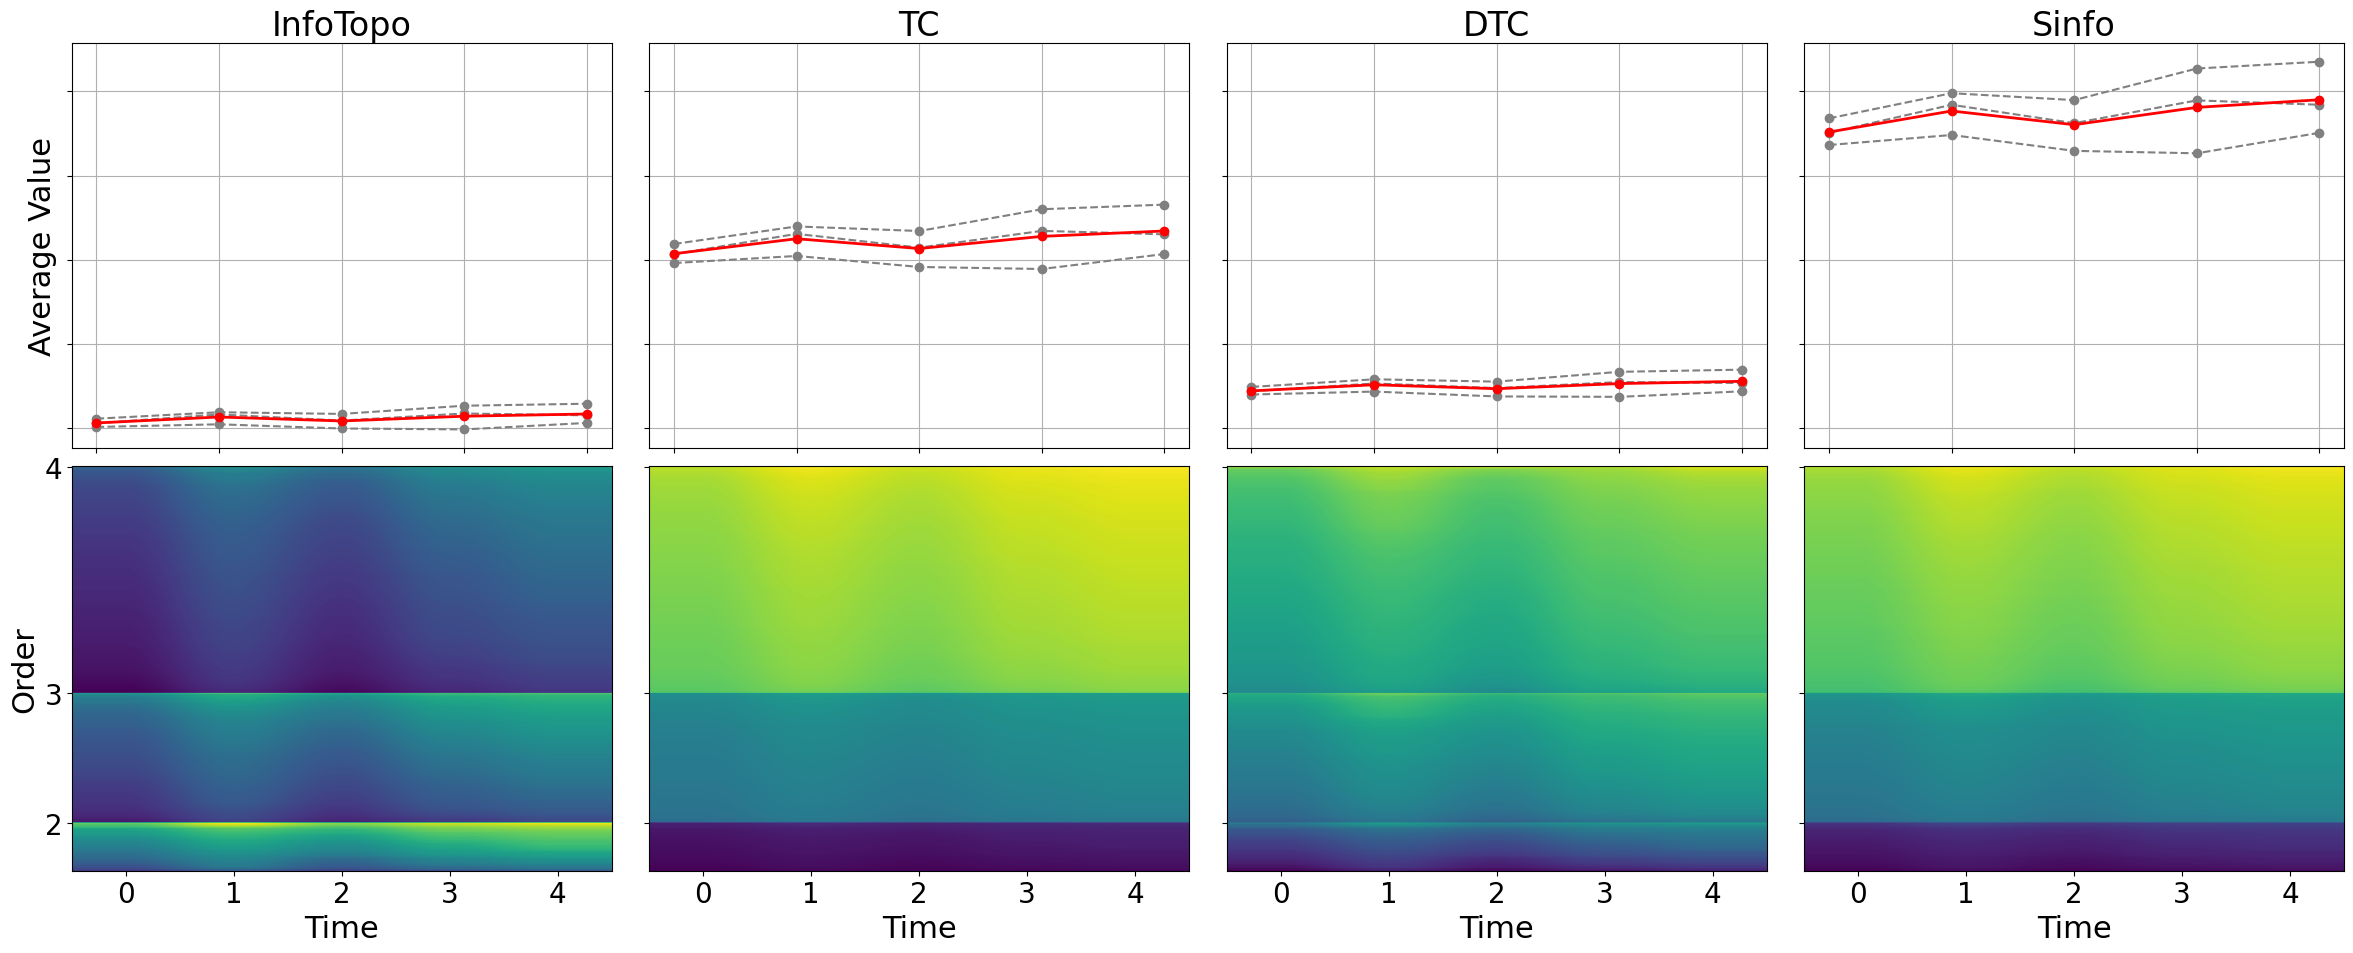

In [9]:
# Prepare data for all metrics
prepared_data = [average_metric_data(m) for m in metrics]
averages = [compute_averages(m) for m in metrics]

timesteps = list(range(1, len(metrics[0][0]) + 1))  # assumes same length for all metrics

# Adjust all font sizes globally
fontsize_standard = 20
plt.rcParams.update({
    'font.size': fontsize_standard+2,
    'axes.titlesize': fontsize_standard+4,
    'axes.labelsize': fontsize_standard+2,
    'xtick.labelsize': fontsize_standard,
    'ytick.labelsize': fontsize_standard,
    'legend.fontsize': fontsize_standard
})

# Setup figure with 2 rows and len(metrics) columns
fig, axs = plt.subplots(2, len(metrics), figsize=(6 * len(metrics), 10), sharey='row')

# If only one metric, axs will be 1D, fix to 2D for consistent indexing
if len(metrics) == 1:
    axs = np.array(axs).reshape(2, 1)

# Top row: line plots
for i, (ax, average_tuple, title) in enumerate(zip(
    axs[0],
    averages,
    [f"{metrics_types[i].__name__}" for i in range(len(metrics))]
)):
    *individual_sim_avgs, avg_combined = average_tuple  # unpack arbitrary-length tuple

    # Plot each simulation average in gray
    for j, avg_sim in enumerate(individual_sim_avgs):
        ax.plot(timesteps, avg_sim, color='grey', linestyle='--', marker='o', label=f'Simulation {j+1}' if i == 0 else "")

    # Plot combined average in red
    ax.plot(timesteps, avg_combined, color='red', marker='o', linewidth=2, label='Average' if i == 0 else "")

    ax.set_title(title)
    ax.set_xticklabels([])

    if i == 0:
        ax.set_ylabel("Average Value")
    else:
        ax.set_yticklabels([])

    ax.grid(True)

# Bottom row: heatmaps
for i, (ax, (data, labels, label_positions), title) in enumerate(zip(
    axs[1],
    prepared_data,
    [f"Heatmap: Metric {i+1}" for i in range(len(metrics))]
)):
    cax = ax.imshow(data.T, aspect='auto', cmap='viridis', origin='lower')
    ax.set_xlabel("Time")
    ax.set_xticks(np.arange(data.shape[0]))
    ax.set_xticklabels(np.arange(data.shape[0]))

    if i == 0:
        ax.set_ylabel("Order")
        yticks = list(label_positions.values())
        ylabels = labels
        ax.set_yticks(yticks)
        ax.set_yticklabels(ylabels)

plt.tight_layout(h_pad=0.1)
plt.show()

# Compute information metrics

In [61]:
# Import libraries
import numpy as np
import pandas as pd
from collections import defaultdict
import hoi
from hoi.plot import plot_landscape
from hoi.utils import get_nbest_mult
from numpy import random
import matplotlib.pyplot as plt
from hoi.metrics import InfoTopo, TC, DTC, Sinfo, Oinfo, RedundancyphiID, SynergyphiID
from hoi.core import entropy_hist

In [104]:
# Define functions
# Function to compute a desired information metric
def compute_information_metric(metric, data):
    data_array=np.array(np.array(data)).astype(float)
    model = metric(data_array)
    metric_results = model.fit(minsize=2,maxsize=5)
    return metric_results, model

# Function to divide list into list per order
def divide_list_into_orders(hoi, model):
    minsize = None
    maxsize = None

    # get orders
    if model:
        orders = model.order

    # get computed orders
    if minsize is None:
        minsize = orders.min()
    if maxsize is None:
        maxsize = orders.max()   

    # order selection
    keep = np.logical_and(orders >= minsize, orders <= maxsize)
    hoi = hoi[keep]
    orders = orders[keep]

    # Group the values per order
    grouped = defaultdict(list)
    for o, h in zip(orders, hoi):
        grouped[o].append(h.item())  # Convert from NumPy array to float

    # Sort each list
    for key in grouped:
        grouped[key] = sorted(grouped[key])

    return grouped

# Obtain information metric analysis
def analyse_information_metric(metric, data):
    # Compute information metric
    metric_values, model = compute_information_metric(metric, data)
    
    # Divide list into lists per order
    divided_dict = divide_list_into_orders(metric_values, model)

    return divided_dict

In [114]:
# Example timeseries
n_timesteps = 20
n_variables = 3

data = np.random.randn(n_timesteps, n_variables)
columns = [f'X{i+1}' for i in range(n_variables)]
df_1 = pd.DataFrame(data, columns=columns)

In [115]:
# Example timeseries
n_timesteps = 20
n_variables = 3

data = np.random.randn(n_timesteps, n_variables)
columns = [f'X{i+1}' for i in range(n_variables)]
df_2 = pd.DataFrame(data, columns=columns)

In [124]:
metrics_types = [InfoTopo, TC, DTC, Sinfo, Oinfo, RedundancyphiID, SynergyphiID]
metric_dicts = []

for metric in metrics_types:
    metric_dict_t1 = dict(analyse_information_metric(metric, df_1[:10]))
    metric_dict_t2 = dict(analyse_information_metric(metric, df_1[10:20]))
    metric_sim1 = [metric_dict_t1, metric_dict_t2]

    metric_dict_t1 = dict(analyse_information_metric(metric, df_2[:10]))
    metric_dict_t2 = dict(analyse_information_metric(metric, df_2[10:20]))
    metric_sim2 = [metric_dict_t1, metric_dict_t2]

    metric_dicts.append((metric_sim1, metric_sim2))

Compute entropy with gc
    Copnorm and demean the data
Get list of multiplets


  0%|          |  0/3 [00:00<?,       ?it/s]

Get list of multiplets


  0%|          | 0/4 [00:00<?, ?it/s]

Compute entropy with gc
    Copnorm and demean the data
Get list of multiplets


  0%|          |  0/3 [00:00<?,       ?it/s]

Get list of multiplets


  0%|          | 0/4 [00:00<?, ?it/s]

Compute entropy with gc
    Copnorm and demean the data
Get list of multiplets


  0%|          |  0/3 [00:00<?,       ?it/s]

Get list of multiplets


  0%|          | 0/4 [00:00<?, ?it/s]

Compute entropy with gc
    Copnorm and demean the data
Get list of multiplets


  0%|          |  0/3 [00:00<?,       ?it/s]

Get list of multiplets


  0%|          | 0/4 [00:00<?, ?it/s]

    Copnorm and demean the data
Get list of multiplets


  0%|          |  0/2 [00:00<?,       ?it/s]

    Copnorm and demean the data
Get list of multiplets


  0%|          |  0/2 [00:00<?,       ?it/s]

    Copnorm and demean the data
Get list of multiplets


  0%|          |  0/2 [00:00<?,       ?it/s]

    Copnorm and demean the data
Get list of multiplets


  0%|          |  0/2 [00:00<?,       ?it/s]

    Copnorm and demean the data
Get list of multiplets


  0%|          |  0/2 [00:00<?,       ?it/s]

    Copnorm and demean the data
Get list of multiplets


  0%|          |  0/2 [00:00<?,       ?it/s]

    Copnorm and demean the data
Get list of multiplets


  0%|          |  0/2 [00:00<?,       ?it/s]

    Copnorm and demean the data
Get list of multiplets


  0%|          |  0/2 [00:00<?,       ?it/s]

    Copnorm and demean the data
Get list of multiplets


  0%|          |  0/2 [00:00<?,       ?it/s]

    Copnorm and demean the data
Get list of multiplets


  0%|          |  0/2 [00:00<?,       ?it/s]

    Copnorm and demean the data
Get list of multiplets


  0%|          |  0/2 [00:00<?,       ?it/s]

    Copnorm and demean the data
Get list of multiplets


  0%|          |  0/2 [00:00<?,       ?it/s]

    Copnorm and demean the data
Get list of multiplets


  0%|          |  0/2 [00:00<?,       ?it/s]

    Copnorm and demean the data
Get list of multiplets


  0%|          |  0/2 [00:00<?,       ?it/s]

    Copnorm and demean the data
Get list of multiplets


  0%|          |  0/2 [00:00<?,       ?it/s]

    Copnorm and demean the data
Get list of multiplets


  0%|          |  0/2 [00:00<?,       ?it/s]

    Copnorm and demean the data
Get list of multiplets


  0%|          |  0/2 [00:00<?,       ?it/s]

    Copnorm and demean the data
Get list of multiplets


  0%|          |  0/2 [00:00<?,       ?it/s]

    Copnorm and demean the data
Get list of multiplets


  0%|          |  0/2 [00:00<?,       ?it/s]

    Copnorm and demean the data
Get list of multiplets


  0%|          |  0/2 [00:00<?,       ?it/s]

    Copnorm and demean the data
Get list of multiplets


  0%|          |  0/2 [00:00<?,       ?it/s]

    Copnorm and demean the data
Get list of multiplets


  0%|          |  0/2 [00:00<?,       ?it/s]

    Copnorm and demean the data
Get list of multiplets


  0%|          |  0/2 [00:00<?,       ?it/s]

    Copnorm and demean the data
Get list of multiplets


  0%|          |  0/2 [00:00<?,       ?it/s]

In [125]:
metrics = metric_dicts

# Test on dataset from stored data

In [ ]:
# Example timeseries
n_timesteps = 20
n_variables = 3

data = np.random.randn(n_timesteps, n_variables)
columns = [f'X{i+1}' for i in range(n_variables)]
df_2 = pd.DataFrame(data, columns=columns)

In [145]:
# Sliding timewindow to compute metrics per timestep for one simulation
def sliding_window(timeseries, windowsize, stepsize):
    metric_dict_list = []
    for i in np.arange(0, len(timeseries)-windowsize, stepsize):
        metric_dict_step = dict(analyse_information_metric(metric, df_1[i:i+windowsize]))
        metric_dict_list.append(metric_dict_step)
    return metric_dict_list

In [ ]:
metrics_types = [InfoTopo, TC, DTC, Sinfo, Oinfo, RedundancyphiID, SynergyphiID]
metric_dicts = []

for metric in metrics_types:
    metric_dict_t1 = dict(analyse_information_metric(metric, df_1[:10]))
    metric_dict_t2 = dict(analyse_information_metric(metric, df_1[10:20]))
    metric_sim1 = [metric_dict_t1, metric_dict_t2]

    metric_dict_t1 = dict(analyse_information_metric(metric, df_2[:10]))
    metric_dict_t2 = dict(analyse_information_metric(metric, df_2[10:20]))
    metric_sim2 = [metric_dict_t1, metric_dict_t2]

    metric_dicts.append((metric_sim1, metric_sim2))

In [167]:
import os
import pandas as pd
import glob

# Define the directory path (use raw string or double backslashes for Windows paths)
directory = r'Data\Artificial_data\Redundant_timeseries'

# Use glob to get all CSV file paths
csv_files = glob.glob(os.path.join(directory, '*.csv'))

# Loop through and load each CSV file into a DataFrame
metric_dicts = []

for metric in metrics_types[:4]:
    metric_sims = []
    for file in csv_files:
        df = pd.read_csv(file)

        windowsize = 80 #int(len(df) / 2)
        stepsize = int(len(df) / 10)

        metric_dict_list = sliding_window(df, windowsize, stepsize)

        metric_sims.append(metric_dict_list)
    metric_dicts.append(tuple(metric_sims))

metrics = metric_dicts

Compute entropy with gc
    Copnorm and demean the data
Get list of multiplets


  0%|          |  0/3 [00:00<?,       ?it/s]

Get list of multiplets


  0%|          | 0/4 [00:00<?, ?it/s]

Compute entropy with gc
    Copnorm and demean the data
Get list of multiplets


  0%|          |  0/3 [00:00<?,       ?it/s]

Get list of multiplets


  0%|          | 0/4 [00:00<?, ?it/s]

Compute entropy with gc
    Copnorm and demean the data
Get list of multiplets


  0%|          |  0/3 [00:00<?,       ?it/s]

Get list of multiplets


  0%|          | 0/4 [00:00<?, ?it/s]

Compute entropy with gc
    Copnorm and demean the data
Get list of multiplets


  0%|          |  0/3 [00:00<?,       ?it/s]

Get list of multiplets


  0%|          | 0/4 [00:00<?, ?it/s]

Compute entropy with gc
    Copnorm and demean the data
Get list of multiplets


  0%|          |  0/3 [00:00<?,       ?it/s]

Get list of multiplets


  0%|          | 0/4 [00:00<?, ?it/s]

Compute entropy with gc
    Copnorm and demean the data
Get list of multiplets


  0%|          |  0/3 [00:00<?,       ?it/s]

Get list of multiplets


  0%|          | 0/4 [00:00<?, ?it/s]

    Copnorm and demean the data
Get list of multiplets


  0%|          |  0/2 [00:00<?,       ?it/s]

    Copnorm and demean the data
Get list of multiplets


  0%|          |  0/2 [00:00<?,       ?it/s]

    Copnorm and demean the data
Get list of multiplets


  0%|          |  0/2 [00:00<?,       ?it/s]

    Copnorm and demean the data
Get list of multiplets


  0%|          |  0/2 [00:00<?,       ?it/s]

    Copnorm and demean the data
Get list of multiplets


  0%|          |  0/2 [00:00<?,       ?it/s]

    Copnorm and demean the data
Get list of multiplets


  0%|          |  0/2 [00:00<?,       ?it/s]

    Copnorm and demean the data
Get list of multiplets


  0%|          |  0/2 [00:00<?,       ?it/s]

    Copnorm and demean the data
Get list of multiplets


  0%|          |  0/2 [00:00<?,       ?it/s]

    Copnorm and demean the data
Get list of multiplets


  0%|          |  0/2 [00:00<?,       ?it/s]

    Copnorm and demean the data
Get list of multiplets


  0%|          |  0/2 [00:00<?,       ?it/s]

    Copnorm and demean the data
Get list of multiplets


  0%|          |  0/2 [00:00<?,       ?it/s]

    Copnorm and demean the data
Get list of multiplets


  0%|          |  0/2 [00:00<?,       ?it/s]

    Copnorm and demean the data
Get list of multiplets


  0%|          |  0/2 [00:00<?,       ?it/s]

    Copnorm and demean the data
Get list of multiplets


  0%|          |  0/2 [00:00<?,       ?it/s]

    Copnorm and demean the data
Get list of multiplets


  0%|          |  0/2 [00:00<?,       ?it/s]

    Copnorm and demean the data
Get list of multiplets


  0%|          |  0/2 [00:00<?,       ?it/s]

    Copnorm and demean the data
Get list of multiplets


  0%|          |  0/2 [00:00<?,       ?it/s]

    Copnorm and demean the data
Get list of multiplets


  0%|          |  0/2 [00:00<?,       ?it/s]

In [ ]:
import os
import pandas as pd
import glob

# Define the directory path (use raw string or double backslashes for Windows paths)
directory = r'Data\Artificial_data\Redundant_timeseries'

# Use glob to get all CSV file paths
csv_files = glob.glob(os.path.join(directory, '*.csv'))

# Loop through and load each CSV file into a DataFrame
metric_dicts = []

for file in csv_files:
    df = pd.read_csv(file)

    windowsize = 80 #int(len(df) / 2)
    stepsize = int(len(df) / 10)

    metric_dict_list = sliding_window(df, windowsize, stepsize)

    metric_dicts.append(metric_dict_list)

metrics = metric_dicts

    Copnorm and demean the data
Get list of multiplets


  0%|          |  0/2 [00:00<?,       ?it/s]

    Copnorm and demean the data
Get list of multiplets


  0%|          |  0/2 [00:00<?,       ?it/s]

    Copnorm and demean the data
Get list of multiplets


  0%|          |  0/2 [00:00<?,       ?it/s]

    Copnorm and demean the data
Get list of multiplets


  0%|          |  0/2 [00:00<?,       ?it/s]

    Copnorm and demean the data
Get list of multiplets


  0%|          |  0/2 [00:00<?,       ?it/s]

    Copnorm and demean the data
Get list of multiplets


  0%|          |  0/2 [00:00<?,       ?it/s]

In [160]:
metrics

[([{2: [-0.03514885902404785, -0.020809292793273926, -0.006348967552185059],
    3: [-0.004250526428222656]},
   {2: [-0.07414674758911133, -0.04209589958190918, 0.15847539901733398],
    3: [-0.08505582809448242]}],
  [{2: [-0.03514885902404785, -0.020809292793273926, -0.006348967552185059],
    3: [-0.004250526428222656]},
   {2: [-0.07414674758911133, -0.04209589958190918, 0.15847539901733398],
    3: [-0.08505582809448242]}],
  [{2: [-0.03514885902404785, -0.020809292793273926, -0.006348967552185059],
    3: [-0.004250526428222656]},
   {2: [-0.07414674758911133, -0.04209589958190918, 0.15847539901733398],
    3: [-0.08505582809448242]}]),
 ([{2: [-0.0351492203772068, -0.02080930769443512, -0.006349006202071905],
    3: [-0.05805690586566925]},
   {2: [-0.07414662837982178, -0.04209594428539276, 0.1584753841161728],
    3: [0.1272881031036377]}],
  [{2: [-0.0351492203772068, -0.02080930769443512, -0.006349006202071905],
    3: [-0.05805690586566925]},
   {2: [-0.07414662837982178, 

In [155]:
metrics

[({2: [0.015218179672956467, 0.07766617089509964, 0.12779954075813293],
   3: [0.08225119113922119]},
  {2: [0.02304910123348236, 0.08130251616239548, 0.09404154866933823],
   3: [0.048440270125865936]}),
 ({2: [0.015218179672956467, 0.07766617089509964, 0.12779954075813293],
   3: [0.08225119113922119]},
  {2: [0.02304910123348236, 0.08130251616239548, 0.09404154866933823],
   3: [0.048440270125865936]}),
 ({2: [0.015218179672956467, 0.07766617089509964, 0.12779954075813293],
   3: [0.08225119113922119]},
  {2: [0.02304910123348236, 0.08130251616239548, 0.09404154866933823],
   3: [0.048440270125865936]})]

In [ ]:
metrics_types = [InfoTopo, TC, DTC, Sinfo, Oinfo, RedundancyphiID, SynergyphiID]
metric_dicts = []

for metric in metrics_types:
    metric_dict_t1 = dict(analyse_information_metric(metric, df_1[:10]))
    metric_dict_t2 = dict(analyse_information_metric(metric, df_1[10:20]))
    metric_sim1 = [metric_dict_t1, metric_dict_t2]

    metric_dict_t1 = dict(analyse_information_metric(metric, df_2[:10]))
    metric_dict_t2 = dict(analyse_information_metric(metric, df_2[10:20]))
    metric_sim2 = [metric_dict_t1, metric_dict_t2]

    metric_dicts.append((metric_sim1, metric_sim2))

# Test visualisation on example data before continuing to sliding window

In [148]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

In [149]:
# Define functions
def average_metric_data(metric):
    # Get all key-index combinations
    all_key_indices = set()
    for sim in metric:
        for d in sim:
            for k, v in d.items():
                for i in range(len(v)):
                    all_key_indices.add((k, i))
    
    sorted_keys = sorted(all_key_indices)  # sort by key then index

    data = []
    for t in range(len(metric[0])):  # number of timesteps
        averaged_dict = {}
        for k, idx in sorted_keys:
            values = [sim[t].get(k, [0.0] * (idx + 1))[idx] for sim in metric]
            averaged_dict[(k, idx)] = np.mean(values)
        sorted_values = [averaged_dict[(k, idx)] for k, idx in sorted_keys]
        data.append(sorted_values)

    # Compute label positions per key
    key_indices = defaultdict(list)
    for idx, (k, _) in enumerate(sorted_keys):
        key_indices[k].append(idx)

    label_positions = {k: max(idxs) for k, idxs in key_indices.items()}
    labels = [f"{k}" for k in label_positions.keys()]  # optional: add count

    return np.array(data), labels, label_positions

def compute_averages(metric):
    sim1, sim2 = metric
    avg_sim1 = [np.mean([v for lst in d.values() for v in lst]) for d in sim1]
    avg_sim2 = [np.mean([v for lst in d.values() for v in lst]) for d in sim2]
    avg_combined = [(a + b) / 2 for a, b in zip(avg_sim1, avg_sim2)]
    return avg_sim1, avg_sim2, avg_combined

In [166]:
# Define functions
def average_metric_data(metric):
    # Get all key-index combinations
    all_key_indices = set()
    for sim in metric:
        for d in sim:
            for k, v in d.items():
                for i in range(len(v)):
                    all_key_indices.add((k, i))
    
    sorted_keys = sorted(all_key_indices)  # sort by key then index

    data = []
    for t in range(len(metric[0])):  # number of timesteps
        averaged_dict = {}
        for k, idx in sorted_keys:
            values = [sim[t].get(k, [0.0] * (idx + 1))[idx] for sim in metric]
            averaged_dict[(k, idx)] = np.mean(values)
        sorted_values = [averaged_dict[(k, idx)] for k, idx in sorted_keys]
        data.append(sorted_values)

    # Compute label positions per key
    key_indices = defaultdict(list)
    for idx, (k, _) in enumerate(sorted_keys):
        key_indices[k].append(idx)

    label_positions = {k: max(idxs) for k, idxs in key_indices.items()}
    labels = [f"{k}" for k in label_positions.keys()]  # optional: add count

    return np.array(data), labels, label_positions

def compute_averages(metric):
    num_simulations = len(metric)
    sim_averages = []

    # Compute average per timestep for each simulation
    for sim in metric:
        avg = [np.mean([v for lst in d.values() for v in lst]) for d in sim]
        sim_averages.append(avg)

    # Compute average across simulations at each timestep
    avg_combined = [
        np.mean([sim_avg[i] for sim_avg in sim_averages])
        for i in range(len(sim_averages[0]))
    ]

    return (*sim_averages, avg_combined)

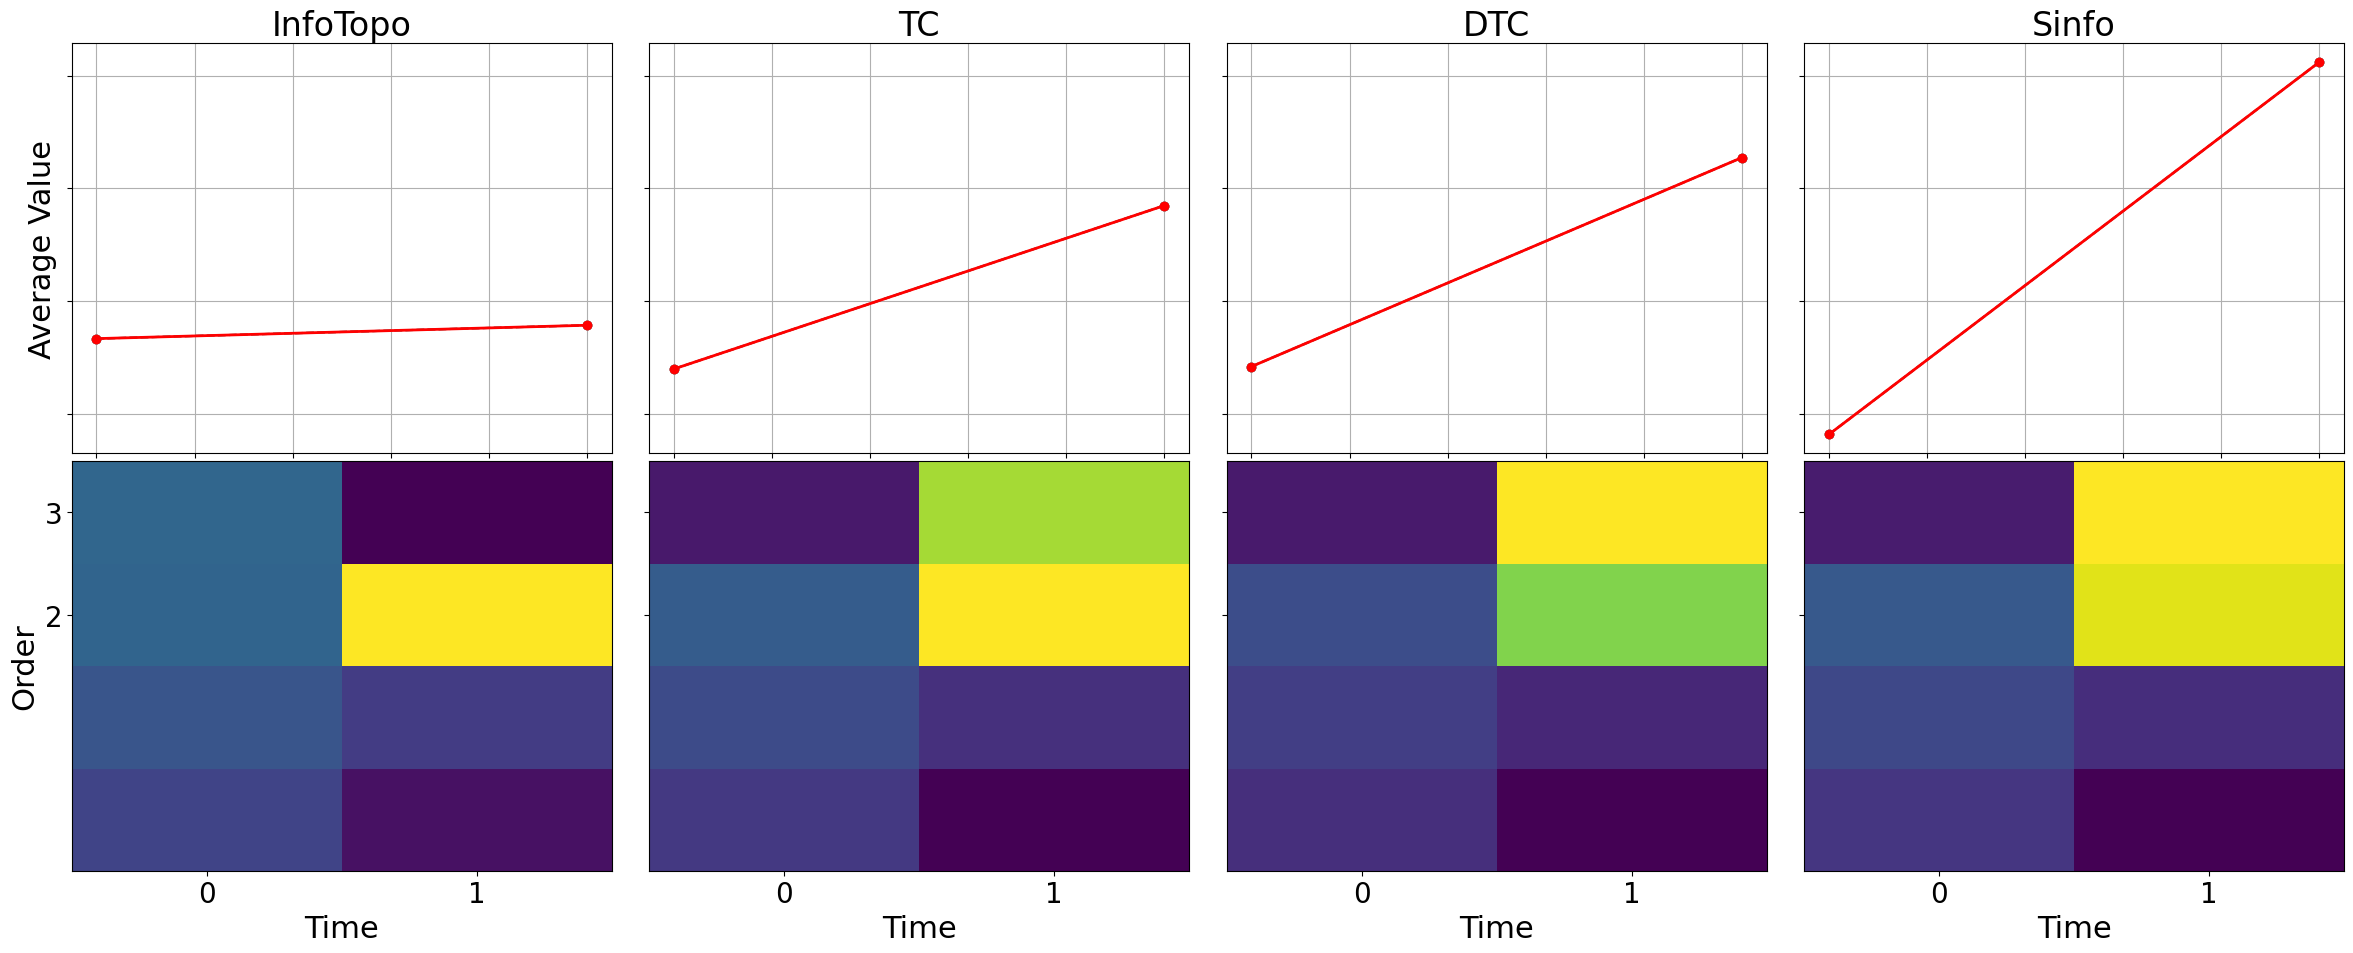

In [173]:
# Prepare data for all metrics
prepared_data = [average_metric_data(m) for m in metrics]
averages = [compute_averages(m) for m in metrics]

timesteps = list(range(1, len(metrics[0][0]) + 1))  # assumes same length for all metrics

# Adjust all font sizes globally
fontsize_standard = 20
plt.rcParams.update({
    'font.size': fontsize_standard+2,
    'axes.titlesize': fontsize_standard+4,
    'axes.labelsize': fontsize_standard+2,
    'xtick.labelsize': fontsize_standard,
    'ytick.labelsize': fontsize_standard,
    'legend.fontsize': fontsize_standard
})

# Setup figure with 2 rows and len(metrics) columns
fig, axs = plt.subplots(2, len(metrics), figsize=(6 * len(metrics), 10), sharey='row')

# If only one metric, axs will be 1D, fix to 2D for consistent indexing
if len(metrics) == 1:
    axs = np.array(axs).reshape(2, 1)

# Top row: line plots
for i, (ax, average_tuple, title) in enumerate(zip(
    axs[0],
    averages,
    [f"{metrics_types[i].__name__}" for i in range(len(metrics))]
)):
    *individual_sim_avgs, avg_combined = average_tuple  # unpack arbitrary-length tuple

    # Plot each simulation average in gray
    for j, avg_sim in enumerate(individual_sim_avgs):
        ax.plot(timesteps, avg_sim, color='grey', linestyle='--', marker='o', label=f'Simulation {j+1}' if i == 0 else "")

    # Plot combined average in red
    ax.plot(timesteps, avg_combined, color='red', marker='o', linewidth=2, label='Average' if i == 0 else "")

    ax.set_title(title)
    ax.set_xticklabels([])

    if i == 0:
        ax.set_ylabel("Average Value")
    else:
        ax.set_yticklabels([])

    ax.grid(True)

# Bottom row: heatmaps
for i, (ax, (data, labels, label_positions), title) in enumerate(zip(
    axs[1],
    prepared_data,
    [f"Heatmap: Metric {i+1}" for i in range(len(metrics))]
)):
    cax = ax.imshow(data.T, aspect='auto', cmap='viridis', origin='lower')
    ax.set_xlabel("Time")
    ax.set_xticks(np.arange(data.shape[0]))
    ax.set_xticklabels(np.arange(data.shape[0]))

    if i == 0:
        ax.set_ylabel("Order")
        yticks = list(label_positions.values())
        ylabels = labels
        ax.set_yticks(yticks)
        ax.set_yticklabels(ylabels)

# Add legend only to the first plot
# axs[0][0].legend()

plt.tight_layout(h_pad=0.1)
plt.show()


ValueError: too many values to unpack (expected 3)

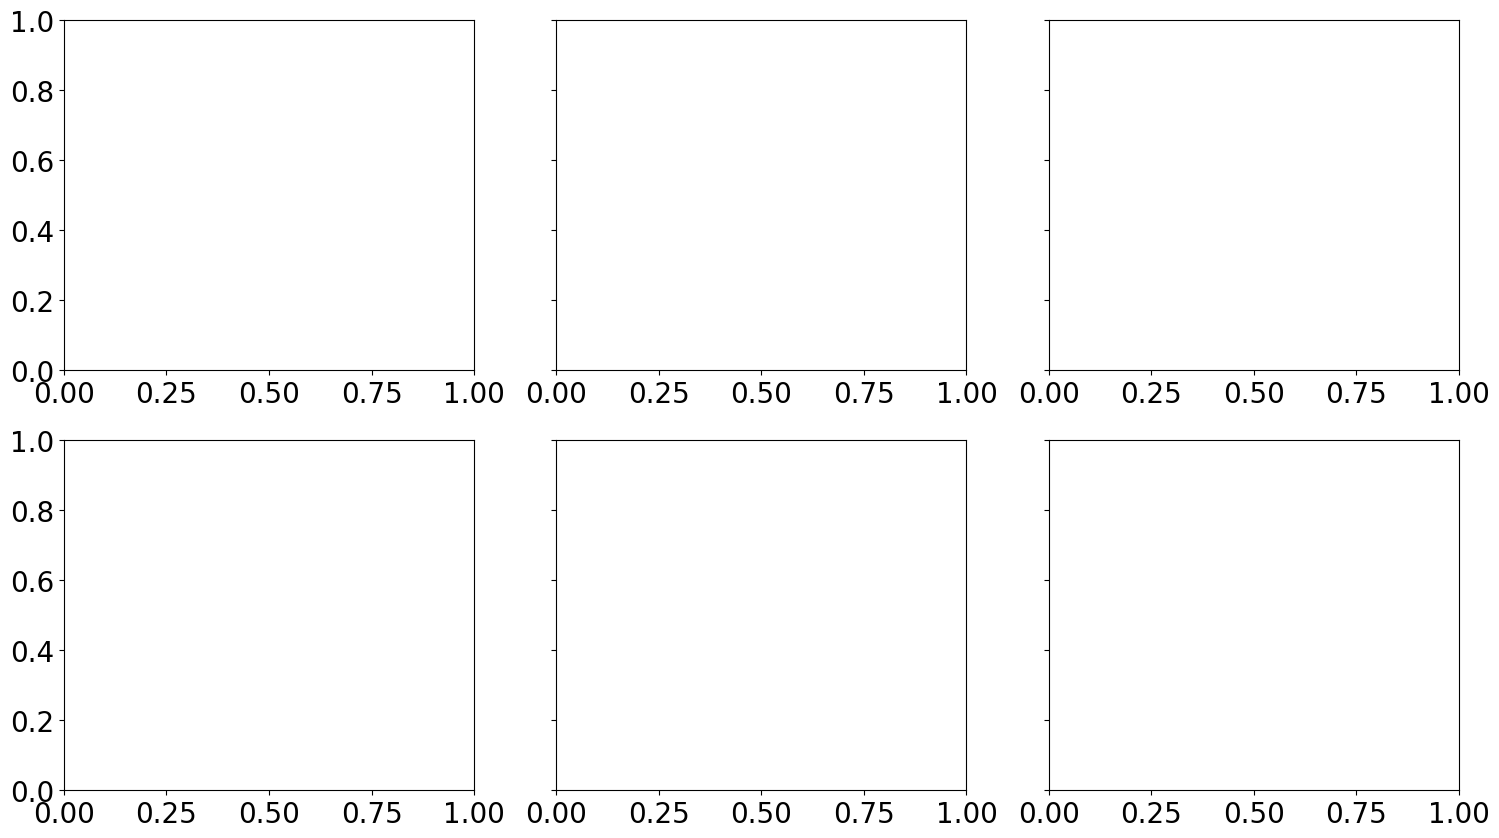

In [163]:
# Prepare data for all metrics
prepared_data = [average_metric_data(m) for m in metrics]
averages = [compute_averages(m) for m in metrics]

timesteps = list(range(1, len(metrics[0][0]) + 1))  # assumes same length for all metrics

# Adjust all font sizes globally
fontsize_standard = 20
plt.rcParams.update({
    'font.size': fontsize_standard+2,
    'axes.titlesize': fontsize_standard+4,
    'axes.labelsize': fontsize_standard+2,
    'xtick.labelsize': fontsize_standard,
    'ytick.labelsize': fontsize_standard,
    'legend.fontsize': fontsize_standard
})

# Setup figure with 2 rows and len(metrics) columns
fig, axs = plt.subplots(2, len(metrics), figsize=(6 * len(metrics), 10), sharey='row')

# If only one metric, axs will be 1D, fix to 2D for consistent indexing
if len(metrics) == 1:
    axs = np.array(axs).reshape(2,1)

# Top row: line plots
for i, (ax, (avg_sim1, avg_sim2, avg_combined), title) in enumerate(zip(
    axs[0],
    averages,
    [f"{metrics_types[i].__name__}" for i in range(len(metrics))]
)):
    ax.plot(timesteps, avg_sim1, color='grey', linestyle='--', marker='o', label='Simulation 1')
    ax.plot(timesteps, avg_sim2, color='grey', linestyle='--', marker='o', label='Simulation 2')
    ax.plot(timesteps, avg_combined, color='red', marker='o', linewidth=2, label='Average')
    ax.set_title(title)
    ax.set_xticklabels([])

    if i == 0:
        ax.set_ylabel("Average Value")
    else:
        ax.set_yticklabels([])

    ax.grid(True)

# Bottom row: heatmaps
for i, (ax, (data, labels, label_positions), title) in enumerate(zip(
    axs[1],
    prepared_data,
    [f"Heatmap: Metric {i+1}" for i in range(len(metrics))]
)):
    cax = ax.imshow(data.T, aspect='auto', cmap='viridis', origin='lower')
    ax.set_xlabel("Time")
    ax.set_xticks(np.arange(data.shape[0]))
    ax.set_xticklabels(np.arange(data.shape[0]))

    if i == 0:
        ax.set_ylabel("Order")
        yticks = list(label_positions.values())
        ylabels = labels
        ax.set_yticks(yticks)
        ax.set_yticklabels(ylabels)

plt.tight_layout(h_pad=0.1)
plt.show()